## AggMap HPs


**AggMap** is divided into 3 stages of *initialization*, *fitting*, and *transformation*, which is useful for learning low-sample labeled data because higher-sample unlabeled data may be used for training AggMap, because the intrinsic relationship between FPs may be better exposed by higher-sample data. **AggMap** can be dumped into local disk and reloaded next time for re-fitting or transformation.

Unsupervised **AggMap** operates in separate fitting and transformation stages for enabling transfer learning. The fitting operation can be trained on higher-sample data and subsequently used for transforming low-sample data. In the fitting stage, AggMap inputs are tabular data matrix of size (n, p) to calculate the correlation distance of feature points (FPs) for performing manifold 2D embedding and clustering, where n and p are the number of samples and FPs, respectively. In the transformation phase, 1D unorder FPs are input to AggMap for transforming into Fmaps, and a scaling method such as minmax or standard scaling was used for scaling the FPs. This setup is useful for learning low-sample data because a larger amount of unlabeled data could be used for fitting and generating AggMap objects to transform low-sample 1D unordered data into structured Fmaps. The intrinsic relationship between FPs could be more accurate if it were determined by higher-sample data and exposed by manifold-based learning. We found that the unsupervised transferable AggMap could boost the classification accuracy of AggMapNet if it were pre-fitted on higher sample unlabeled data.


![xx](./fit_transform_seperate.png)
*The fit and transform operations in the AggMap tool enable the Fmaps transfer learning: the pre-fit AggMap based on unlabeled high-data can be used for low-data feature maps transformation.*
----


The key hyperparameters in each stage of AggMap is provided in Table below. In the *initialization* stage, the pairwise distance matrix of FPs was typically computed by the higher-sample unlabeled data. The *fitting* stage controls how **AggMap** rearranges the FPs. The hyperparameters in this stage are very important, which include non-UMAP-mediated and UMAP-mediated parameters. For the non-UMAP-mediated parameters, `cluster_channels` is the number of clusters of the multi-channel Fmaps (greater number of clusters leads to finer separation of FPs), `var_thr` is the threshold for filtering out lower variance FPs (default is -1, i.e., no FPs are filtered out). For the UMAP-mediated parameters, `n_neighbors` is the k number of nearest neighbours for estimating the manifold structure of the data, `min_dist` is the minimum distance between two FPs that can be explicitly separated and shown in the low dimensional representation, the number of the epochs (`n_epochs`) and learning rate(`lr`) are to minimize the cross-entropy loss to optimize the layout of the low-dimension graph. In the *transformation* stage, the inputs are 1D vectors while the outputs are the structured 3D tensor. The important parameter is the data scaling method. AggMap supports two kinds of data scaling methods: the *minmax* and the *standard* scaling. In minmax scaling, the data is transformed into 0-1 range based on the minimal and maximal value of data. In standard scaling (also called z-score normalization), the feature is standardized by removing the mean and scaling to unit variance.

----


### The important hyperparameters in AggMap feature restructuring


|Stage|Parameter|Default|Description|
|:----|:----|:----|:----|
|Initialization stage|`metric`|correlation|Distance metric to measure the similarities between the FPs|
|Fitting Stage|`emb_method`|umap|Method to embed the feature points(FPs)|
|Fitting Stage|`cluster_channels`|5|Number of the channels / clusters of the feature points|
|Fitting Stage|`var_thr`|-1|Parameter to remove low-variance features. Feature points with variance lower than this threshold will be removed.|
|Fitting Stage|**`n_epochs`**|500|UMAP parameter: Epochs in in minimization the differences of the two weighed graphs|
|Fitting Stage|**`lr`**|1|UMAP parameter:Learning rate in minimization the differences of the two weighed graphs|
|Fitting Stage|**`min_dist`**|0.01|UMAP parameter:The minimum distance apart that points are allowed to be in the low dimensional representation|
|Fitting Stage|**`n_neighbors`**|15|UMAP parameter:K number of nearest neighbours when estimating the manifold structure of the data|
|Transformation stage|`scale_method`|minmax|Data scaling by z-score standard scaling or minmax scaling|



----

### Code example of AggMap feature restructuring.


```python
import pandas as pd
from sklearn.datasets import load_breast_cancer
from aggmap import AggMap, AggMapNet

# Data loading
data = load_breast_cancer()
dfx = pd.DataFrame(data.data, columns=data.feature_names)
dfy = pd.get_dummies(pd.Series(data.target))

# AggMap object Initialization, Fitting, and Saving 
mp = AggMap(dfx, metric = 'correlation')
mp.fit(cluster_channels=5, emb_method = 'umap', verbose=0)
mp.save('agg.mp')

# AggMap visulizations: Hierarchical tree, embeddng scatter and grid
mp.plot_tree()
mp.plot_scatter(enabled_data_labels=True, radius=5)
mp.plot_grid(enabled_data_labels=True)

# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
y = dfy.values
```


## AggMapNet HPs

**AggMapNet** consists of three parts, the input of **AggMap** Fmaps, the CNN-based feature extraction layers, and pyramid fully connected (FC) layers. The first convolutional layer has a larger kernel number for increased data dimension. The max-pooling layer (kernel size=3) has a stride size 2 for more aggressive reduction of the spatial resolution and thus lowering the computational cost.  Choosing the right kernel size for the convolution operation is difficult because different tasks may favor different kernel sizes. For performance improvement, AggMapNet adopts the naïve inception layer of GooLeNet (a top-performer of the ILSVRC-2014 classification task). The inception layer in AggMapNet consists of three small parallel kernels (sizes of 1 × 1, 3 × 3, and 5 × 5) for enhanced local perception. The 1x1 convolution is for cross-channel learning. Subsequently, a global max-pooling (GMP) layer is introduced before a dense layer instead of a flatten layer, which significantly decrease the number of parameters, followed by dense layers for improved nonlinear transformation capability. Overall, AggMapNet has a relatively small number of trainable parameters (~0.3 million) but has a complex topological structure of two inception blocks.

The hyperparameters (**HPs**) and their default setting are in **Table 2**, which include the network architecture parameters (NAPs) and the training-control parameters (TCPs). The NAPs are the kernel size of the first convolutional layer (`conv1_kernel_size`), the number of dense layers and corresponding units (`dense_layers`), dropout rate in the dense layers (`dropout`), number of the inception layers (`n_inception`), and batch normalization after convolution layers. AggMapNet uses a larger kernel size for the first convolutional layer for enabling more expressive power and a global perception. To decrease the trainable parameter, default AggMapNet adopts 2 inception layers and 1 dense layer, and no dropout is used for the dense layer. The TCPs include the number of epochs, learning rate (`lr`), and batch size. The cross-entropy loss was used for both multi-task and binary tasks. During the training, AggMapNet has two important parameters (the monitor and patience) for early stopping. The monitor is the metric performance of the validation set, and the `patience` parameter is the number of epochs with no improvement on the monitor after which training will be stopped.


### The important hyperparameters in AggMapNet


<div align="center">
   <span style="font-weight:bold;">Table 2. The hyperparameters in AggMapNet model.</span>
</div>

|Type|Parameter|Default|Description|
|:----|:----|:----|:----|
|Network Architecture Parameters (NAPs)|`conv1_kernel_size`|13|The kernel size of first convolutional layers, should be odd number|
|Network Architecture Parameters (NAPs)|`dense_layers`|[128]|Number of the pyramidal dense layers and the units per dense layer|
|Network Architecture Parameters (NAPs)|`dense_avf`|relu|Activation function in dense layers|
|Network Architecture Parameters (NAPs)|`dropout`|0|Dropout rate in the dense layers|
|Network Architecture Parameters (NAPs)|`batch_norm`|FALSE|Whether uses the batch normalization after convolution layers or not|
|Network Architecture Parameters (NAPs)|`n_inception`|2|Number of the inception layers|
|Training-Control Parameters (TCPs)|`epochs`|200|Number of the epochs|
|Training-Control Parameters (TCPs)|`lr`|1.00E-04|Learning rate|
|Training-Control Parameters (TCPs)|`batch_size`|32|Batch size|
|Training-Control Parameters (TCPs)|`loss`|MSE / CE|The loss function|
|Training-Control Parameters (TCPs)|`metric`|ACC|Evaluation metric during the training, {'ROC', 'ACC', 'PRC'} in classification tasks, {'rmse', 'r2'} in regression task|
|Training-Control Parameters (TCPs)|`monitor`|val_loss|A monitor for early stopping, can be ''val_loss' and ''val_metric', select the best model by the performance of the validation set|
|Training-Control Parameters (TCPs)|`patience`|1000000|Number of epochs with no improvement on the monitor after which training will be stopped|

----

### Code example of AggMapNet modelling


```python
# AggMapNet training, validation, early stopping, and saving
clf = AggMapNet.MultiClassEstimator(epochs=50, gpuid=0)
clf.fit(X, y, X_valid=None, y_valid=None)
clf.save_model('agg.model')

```


## AggMapNet Explainers

Interpretability of DL and ML models is important for informed decisions, mechanism investigations, biomarker discoveries, and model assessments[1, 2]. However, it is challenging to identify important features effectively and reproducibly based on low-sample data. The perturbation-based model interpretation is an established post hoc feature attribution method for interpreting black box models[3, 4], which interprets predictions by altering or removing parts of input features to assess its influence on the prediction. Kernel Shapley Additive exPlanations (**SHAP**) is such kind of the model interpretation method, which can be used for any black-box model explanation[5]. Kernel SHAP requires a background data set for training, and feature absence is simulated by substituting feature values with prevalent values of training data. The feature importance in kernel Shapley value is measured by comparing the prediction value obtained with the feature and without it[5].
AggMapNet integrated the kernel SHAP method (i. e., the **Shapley-explainer**) as one of the model explainers in AggMapNet. However, AggMapNet also complement a new model explainer, i. e., the **Simply-explainer**. Kernel Shapley method is based on a solid theoretical foundation in game theory and is a popular explainer in local model explanation by calculating the magnitude of feature attributions. Nonetheless, it has several problems in the measurement of feature importance[6]. One problem is that it suffers from the computational complexity in the global explanation for the many samples[6]. Moreover, since kernel SHAP method considers the amount of contribution each feature makes to the model prediction value instead of the true value, thus it may not able to fully explore the global relationship between the features and the true outcomes[7]. The **Simply-explainer** was developed for providing additional means for AggMapNet model explanation. The **Simply-explainer** aims to be faster for calculating the global feature importance of the high-dimensional omics features and to consider the relationship of the features with the true labels.
The perturbation-based interpretation method **Simply-explainer** can be used for both local (individual sample) and global (all samples of a dataset)[8] interpretation tasks. The feature importance (FI) score S in **Simply-explainer** is straightforwardly determined by replacing each FP with a background value, without retraining the model:

!['simply-explainer'](./simply_explainer.png)


The AggMapNet inputs are 4D tensor (batch size, width, height, channels) data in multiple channels. The perturbation only occurs on these meaningful FPs, and the perturbation value is a background value (e.g., zero value for blank pixel) of the input Fmaps. Noted that for the local FI, the model error e is calculated by the log loss of the individual sample prediction values versus true labels across the labels (classes). However, for the global FI, the model error e is calculated by the log loss of the prediction values versus true labels for one class by many samples. That is, in multi-tasks, the Simply-explainer can calculate FI for each class. The global FI based on all samples of a dataset provides a highly compressed, global insight into the behaviours between the feature and true outcomes for the whole dataset in Simply-explainer. In contrast, the local FI reveals the FI that is important to individual sample[8]. The correction of the FI of Simply-explainer includes the logarithm transformation and standard scaling of the FI values to reveal the important FPs. After scaling, those FPs with FI score Fl > 0 are considered notable FPs in a saliency-map for the proposed Simply-explainer. The local or global feature importance (FI) is of a Fmap can be presented as a 2D saliency-map for revealing the important features (Fig. 1C). 
Importantly, the revealed important features by explainers can be presented by a **saliency-map**[9] based on **AggMap**'s 2D grid map (location) of feature points.
-----

### Code example of AggMapNet model explaination


```python
# Model explaination by simply-explainer: global, local
simp_explainer = AggMapNet.simply_explainer(clf, mp)
global_simp_importance = simp_explainer.global_explain(clf.X_, clf.y_)
local_simp_importance = simp_explainer.local_explain(clf.X_[[0]], clf.y_[[0]])

# Model explaination by shapley-explainer: global, local
shap_explainer = AggMapNet.shapley_explainer(clf, mp)
global_shap_importance = shap_explainer.global_explain(clf.X_)
local_shap_importance = shap_explainer.local_explain(clf.X_[[0]])

```

---

### Simply-explainer vs. Shapley-explainer

We first compared the **Simply-explainer** and **Shapley-explainer** on the local explanation of the same MNIST recognition model. The PCC and SSIM between the original image and the explanation saliency-map were used for measuring the explanation performances. **Simply-explainer** tends to score better explanation performance with higher PCC and SSIM values than the **Shapley-explainer** on both explanations of noise-free and noisy test images. Noticeably, **Simply-explainer** focuses on the relationships between the outcomes with the true labels instead of the changes in prediction values, which might be advantageous for better explanation performance.

![mnist_expl2](./mnist_expl2.png)
*Comparison of the Simply-explainer and Shapley-explainer on the noise-free MNIST recognition model explanation. **A**, the ground truth MNIST images, and the interpretation saliency-map images that are generated by Simply-explainer and Shapley-explainer from ground truth images. **B**, the Pearson’s correlation coefficient (PCC) and structure similarity index (SSIM) values between the ground truth images and the interpreted saliency-map images for the two explainers.*

---


We also compared the two explainers on the global explanations of the breast cancer diagnostic model trained on the WDBC dataset (569 samples, 30 features)[10]. The feature importance (FI) score of the two explanations is highly-correlated (Persons’ r = 0.866) to each other. However, the FI scores in **Simply-explainer** tends to be more discrete than **Shapley-explainer**, suggesting that Simply-explainer can be a competitive method for biomarker identifications. The computational complexity for the Simply-explainer is *O(n)*, which is much faster than the kernel Shapley-explainer (The complexity in kernel Shapley-explainer is *O(m\*l\*(2n+2048)*), where l is the number of background samples, n is number of features and m is number of samples(33)) (Supplementary Fig. S12B). These results indicate that Simply-explainer is robust, highly discriminative and fast for the selection of important features, even with noisy data, which is particularly suitable for discovering the key biomarkers in High-dimensional data.



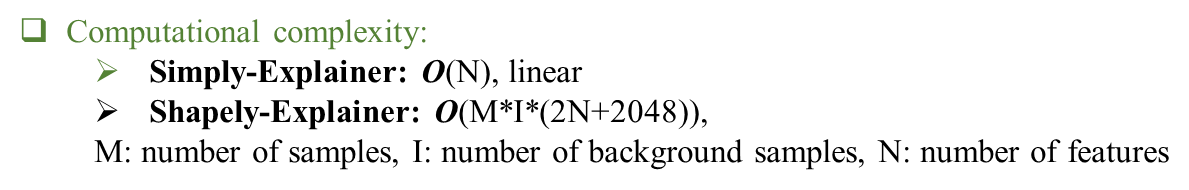
M: number of samples, I: number of background samples, N: number of features

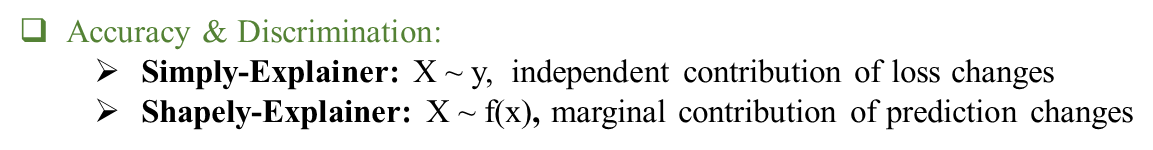


!['simply-Shaply'](./Sim-vs-Shap1.png)
*Comparison of the Simply-explainer and Shapley-explainer on global explanation of breast cancer diagnostic model trained by WDBC dataset[10]. **A**, the joint scatter plot of the global feature importance (GFI) calculated by Simply-explainer and Shapley-explainer. **B**, the time used for the Simply-explainer and Shapley-explainer in the calculation of GFI. Computational complexity for Simply-explainer is O(n), while the complexity for kernel Shapley-explainer is O(m*l*(2n+2048)), where l is the number of background samples, n is number of features and m is number of samples.*


---


### References


**1.**	Lee, H., et al., An explainable deep-learning algorithm for the detection of acute intracranial haemorrhage from small datasets. Nature biomedical engineering, 2019. 3(3): p. 173-182.

**2.**	Samek, W., T. Wiegand, and K.-R. Müller, Explainable artificial intelligence: Understanding, visualizing and interpreting deep learning models. arXiv preprint arXiv:1708.08296, 2017.

**3.**	Ribeiro, M.T., S. Singh, and C. Guestrin. " Why should i trust you?" Explaining the predictions of any classifier. in Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining. 2016.

**4.**	Jiménez-Luna, J., F. Grisoni, and G. Schneider, Drug discovery with explainable artificial intelligence. Nature Machine Intelligence, 2020. 2(10): p. 573-584.

**5.**	Lundberg, S.M. and S.-I. Lee. A unified approach to interpreting model predictions. in Proceedings of the 31st international conference on neural information processing systems. 2017.

**6.**	Kumar, I.E., et al. Problems with Shapley-value-based explanations as feature importance measures. in International Conference on Machine Learning. 2020. PMLR.

**7.**	Fryer, D.V., I. Strümke, and H. Nguyen, Explaining the data or explaining a model? Shapley values that uncover non-linear dependencies. arXiv preprint arXiv:2007.06011, 2020.

**8.**	Lundberg, S.M., et al., From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2020. 2(1): p. 2522-5839.

**9.**	Simonyan, K., A. Vedaldi, and A. Zisserman, Deep inside convolutional networks: Visualising image classification models and saliency maps. arXiv preprint arXiv:1312.6034, 2013.

**10.**	Dua, D. & Graff, C. UCI machine learning repository, Wisconsin Diagnostic Breast Cancer (WDBC) Data Set. URL：https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)  (2019).

----
